## Hecho por: David Ramírez Betancourth
## C.C. 1002636667
## Ingeniería Electrónica
## Universidad Nacional de Colombia Sede Manizales

In [8]:
import matplotlib.pyplot as plt #Graficador
import numpy as np #Opearciones entre arrays
import scipy.signal as sig #métodos de señales (welch)
import scipy.stats as stats


import tensorflow as tf # Red Neuronal
from sklearn.model_selection import train_test_split #Divisor de datos de entrenamiento y testeo
from sklearn.preprocessing import MinMaxScaler #Normalizador de escala
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential #Red Neuronal
from tensorflow.keras.layers import Dense, Dropout, LSTM #Conexión neuronas
from tensorflow.keras.optimizers import Adam #Optimizador de red

#Generar Señal

$f_o = 1 Hz$

$x(t) = cos(\omega_o) - \frac{sin(3\omega_o)}{3} + \frac{cos(5\omega_o)}{5}$

$\xi(t) = x(t) + \eta(t)$

Aplicar método welch: Consiste en hallar la FFT por ventaneos de la señal y luego promediando las PSD de cada segmento

In [9]:
np.random.seed(0)

def randomvector(N, sigma):
    """Genera un vector gaussiano eta = N(0, sigma)"""

    return np.random.normal(0, np.sqrt(sigma), size=N) 

def real_signal(t, wo):
    """x(t)"""

    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)


def welch_vector(X, fs, nperseg):
    """Generar psd de la señal xi
       ventaneo hamming
       overlap del 25% de la vetana
    """

    return sig.welch(X, fs, window='hamming', nperseg=nperseg, noverlap=(nperseg*.25))

N = 1024 #Longitud señal
M = 2000 # No de señales
fo = 1 # 1Hz frecuencia
wo = 2*np.pi*fo
sigma = 0.1  #varianza
nperseg = 501 #Longitud ventana

t = np.linspace(0, 3, N) # vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0]) #Muestreo

X = np.zeros((M, N)) #Matriz vacía de zeros
for i in range(M):
    X_true = real_signal(t, wo) #Generar señal real
    X[i] = X_true + randomvector(N, sigma) #Combinarla con ruido, meterla a la fila

Psd_real = np.zeros((M, (nperseg//2)+1)) # Matriz welch, M señales, longitud psd = (ventaneo//2) +1
for i in range(M):
    f, psd = welch_vector(X[i], fs, nperseg)
    Psd_real[i] = psd

# Preparar Datos

Scaler: normaliza los datos a una escala deseada (0,1)

train test split: Divide los datos un porcentaje deseado 70/30, 70 entrenar, 30 test.

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler.fit_transform(X)
Psd_scaled = scaler.fit_transform(Psd_real)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Psd_scaled, test_size=0.3, random_state=42)

# Red Neuronal Recurrente LSTM

Modelo tipo Sequential(MLP): Las capas se apilan una tras otra, lo que hace que el flujo de datos sea simple y directo. Es LSTM porque se alimenta de los pesos de neuronas adyacentes.

Optimizador Adam: Utiliza AdaGrad y RMSProp. Consiste en:
- Calcular Gradiente
- Se corrige sesgos
- Se actualizan pesos
 



In [12]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])

# Reshape for LSTM data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.0014 - loss: 0.0596 - val_accuracy: 0.0036 - val_loss: 0.0556
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step - accuracy: 0.0132 - loss: 0.0535 - val_accuracy: 0.0107 - val_loss: 0.0428
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.0338 - loss: 0.0386 - val_accuracy: 0.0107 - val_loss: 0.0288
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 410ms/step - accuracy: 0.0371 - loss: 0.0266 - val_accuracy: 0.0107 - val_loss: 0.0219
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.0343 - loss: 0.0213 - val_accuracy: 0.0286 - val_loss: 0.0195
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 408ms/step - accuracy: 0.0222 - loss: 0.0194 - val_accuracy: 0.0250 - val_loss: 0.0188
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 399ms/step - accuracy: 0.0327 - loss: 0.0191 - val_accuracy: 0.0429 - val_loss: 0.0187
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 404ms/step - accuracy: 0.0342 - loss: 0.0191 - val_accu

# Rendimiento del Modelo

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.0448 - loss: 0.0189
Test Loss: 0.018701590597629547, Test MAE: 0.0533333346247673


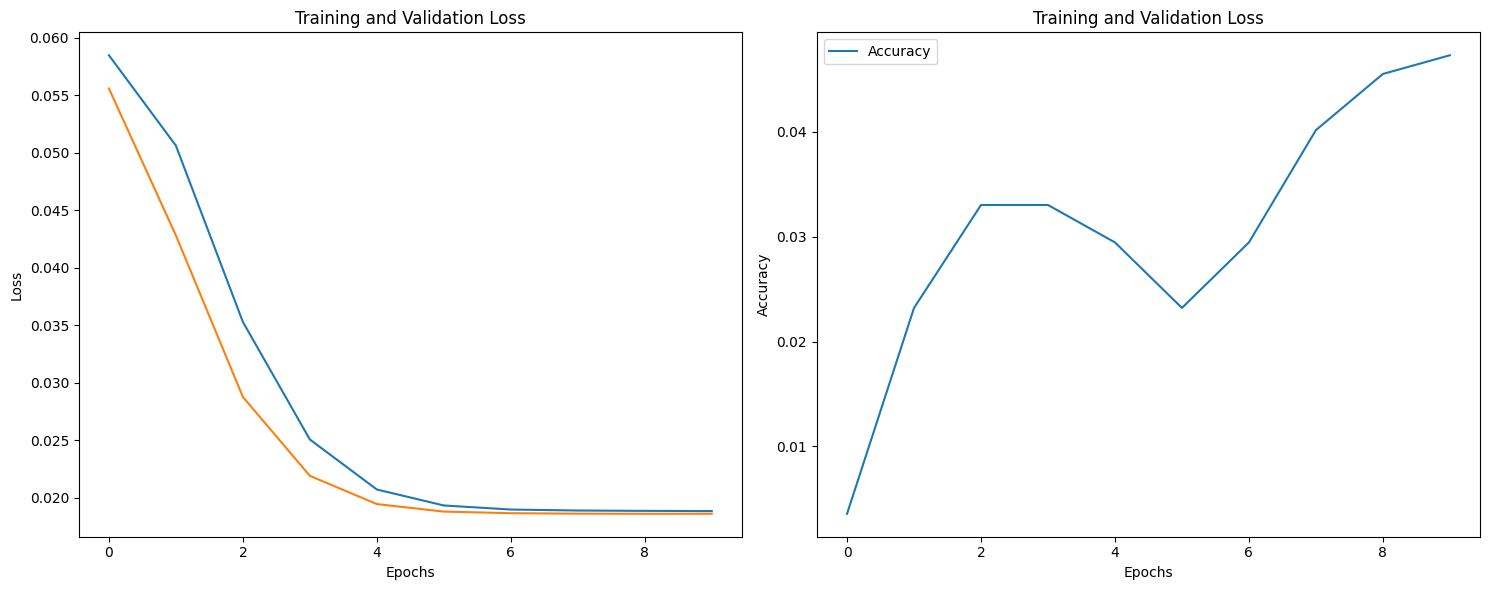

In [20]:
# Evaluar modelo
loss, mae = model.evaluate(X_test_reshaped, y_test) #Saca mae = promedio del error absoluto y pérdidas del modelo
print(f"Test Loss: {loss}, Test MAE: {mae}")


fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(history.history['accuracy'], label='Accuracy')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Predecir

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step


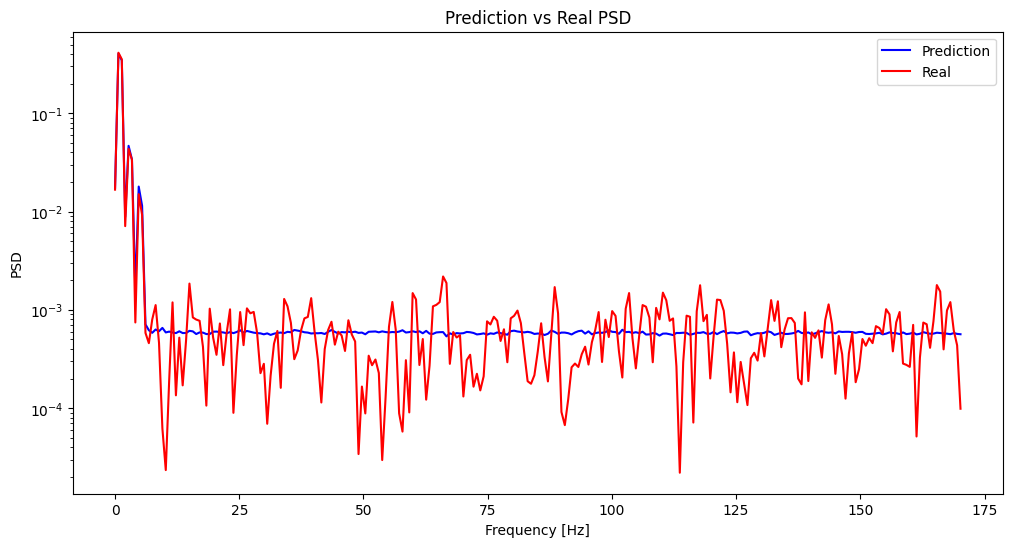

In [21]:
psd_pred_scaled = model.predict(X_test_reshaped)
psd_pred = scaler.inverse_transform(psd_pred_scaled)

plt.figure(figsize=(12, 6))
plt.semilogy(f, psd_pred[50], color='b', label='Prediction')
plt.semilogy(f, Psd_real[50], color='r', label='Real')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Prediction vs Real PSD')
plt.legend()
plt.show()

# Error

In [19]:
print(mean_squared_error(psd_pred[50], Psd_real[50]))

8.434805626602198e-07
